In [1]:
from new_grid import Grid
from graphics import display_grid
from agent import Agent
import matplotlib.pyplot as plt

In [2]:
easy1 = {'train':(1,0),'trainvel':(0,1),'cargo1':(3,2),'num1':1,'target1':(2,2), 'switch':(0,0),'agent':(4,2),'cargo2':(2,4),'num2':2,'target2':(0,3)}

push3 = {"train": (0, 3), "trainvel": (1, 0), "cargo1": (2, 2), "target1": (0, 4), "switch": (2, 4), "agent": (2, 0), "cargo2": (3, 3), "target2": (3, 4),'num1':1, "num2":2}

swit27 = {"train": (1, 0), "trainvel": (0, 1), "cargo1": (0, 1), "target1": (4, 3), "switch": (3, 3), "agent": (4, 4), "cargo2": (1, 2), "target2": (0, 3), 'num1':1, "num2":2}


In [3]:
testgrid = Grid(5, random=False, init_pos=swit27)
display_grid(testgrid)

[['_' '_' '_' '_' '◉']
 ['b' '_' '_' 'S' 'a']
 ['_' '2' '_' '_' '_']
 ['1' '_' '_' '_' '_']
 ['_' '^' '_' '_' '_']]
=====


array([['_', '_', '_', '_', '◉'],
       ['b', '_', '_', 'S', 'a'],
       ['_', '2', '_', '_', '_'],
       ['1', '_', '_', '_', '_'],
       ['_', '^', '_', '_', '_']], dtype='<U1')

In [6]:
#remove softmax from code, change so effects last

x = [0,25,50,75,100,125,150,175]
dual = [0]*len(x)
based = [0]*len(x)
num_avg = 10
agent = Agent()

for idx,iters in enumerate(x):
    for i in range(num_avg):
        Q, policy = agent.mc_first_visit_control(testgrid.copy(), iters=iters, nn_init=True,cutoff=0.4)
        grids,actions,r = agent.run_final_policy(testgrid.copy(), Q,nn_init=True,display=False)
        dual[idx] += r
        
        Q, policy = agent.mc_first_visit_control(testgrid.copy(), iters=iters, nn_init=False)
        grids,actions,r = agent.run_final_policy(testgrid.copy(), Q,nn_init=False,display=False)
        based[idx] += r
       
    
dual = [x/num_avg for x in dual]
based = [x/num_avg for x in based]
print(dual,based)


neural net loaded
[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0] [-2.0, -1.5, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


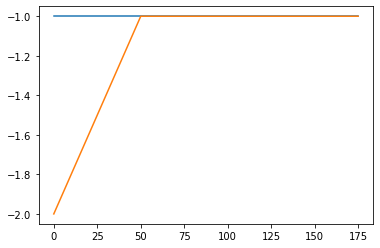

In [8]:
plt.plot(x, dual, label = "dual")
plt.plot(x, based, label = "based")